***Classification of Ants and Bees***
---


*   **Transfer Learning**
*   **Resnet18**
*   **Spinal Net (Instead of Fully Connected Layers)**
*   **Hymenoptera**



**REFERENCES:**

* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

* https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_hymenoptera.py

# The Data

In [1]:
# Mounting Google Drive locally
# Import Google Drive Files and the Dataset
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# chenge the directory
%cd /content/drive/MyDrive/AI/PyTorch/bee_ant_hymenoptera_SpinalNet_TransferLearning

/content/drive/MyDrive/AI/PyTorch/bee_ant_hymenoptera_SpinalNet_TransferLearning


In [5]:
# check the current directory
!pwd

/content/drive/MyDrive/AI/PyTorch/bee_ant_hymenoptera_SpinalNet_TransferLearning


In [ ]:
# download, unzip and load the zipped data
import requests, zipfile, io
r = requests.get("https://download.pytorch.org/tutorial/hymenoptera_data.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/")

# Libraries

In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Data Preperation

In [7]:
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = '/content/drive/MyDrive/AI/PyTorch/bee_ant_hymenoptera_SpinalNet_TransferLearning/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
device

device(type='cuda', index=0)

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

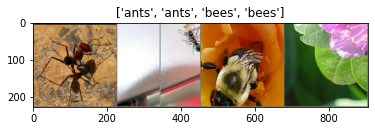

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Spinal Network

In [13]:

half_in_size = 256
first_HL = 5

class SpinalNet(nn.Module):
    def __init__(self):
        super(SpinalNet, self).__init__()
        self.lru = nn.LeakyReLU()
        self.fc1 = nn.Linear(half_in_size, first_HL)
        self.fc2 = nn.Linear(half_in_size+first_HL, first_HL)
        self.fc3 = nn.Linear(half_in_size+first_HL, first_HL)
        self.fc4 = nn.Linear(half_in_size+first_HL, first_HL)
        self.fc5 = nn.Linear(half_in_size+first_HL, first_HL)
        self.fc6 = nn.Linear(half_in_size+first_HL, first_HL)
        
        self.fcx = nn.Linear(first_HL*6, 2)

    def forward(self, x):
        x1 = x[:,0:half_in_size]
        x1 = self.lru(self.fc1(x1))
        x2= torch.cat([ x[:,half_in_size:half_in_size*2], x1], dim=1)
        x2 = self.lru(self.fc2(x2))
        x3= torch.cat([x[:,0:half_in_size], x2], dim=1)
        x3 = self.lru(self.fc3(x3))
        x4= torch.cat([x[:,half_in_size:half_in_size*2], x3], dim=1)
        x4 = self.lru(self.fc4(x4))
        x5= torch.cat([x[:,0:half_in_size], x4], dim=1)
        x5 = self.lru(self.fc3(x5))
        x6= torch.cat([x[:,half_in_size:half_in_size*2], x5], dim=1)
        x6 = self.lru(self.fc4(x6))
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)
        x = torch.cat([x, x5], dim=1)
        x = torch.cat([x, x6], dim=1)
        
        x = self.fcx(x)
        return x


# Training

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
# the model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [17]:
# Changing the fully connected layer to SpinalNet

# instead of using: model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = SpinalNet()

In [18]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
# Training Part
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6388 Acc: 0.6639
val Loss: 0.5027 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4980 Acc: 0.7705
val Loss: 0.2721 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4382 Acc: 0.8156
val Loss: 0.1884 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3322 Acc: 0.8811
val Loss: 0.1791 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3697 Acc: 0.8361
val Loss: 0.1702 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.3898 Acc: 0.8238
val Loss: 0.2019 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3175 Acc: 0.8648
val Loss: 0.1841 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3330 Acc: 0.8525
val Loss: 0.1818 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3154 Acc: 0.8770
val Loss: 0.1813 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2660 Acc: 0.8730
val Loss: 0.2070 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2876 Acc: 0.8689
val Loss: 0.1766 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2276 Acc: 0.9016
val Loss: 0.2005 Acc: 0.9281

Ep

**It is Important to Note That the original reference used only fully connected layers instead of Spinal Network and the Accuracy was obtained as 0.941176 **

In [20]:
repr(model_ft)

'ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (relu): ReLU(inplace=True)\n  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)\n  (layer1): Sequential(\n    (0): BasicBlock(\n      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (relu): ReLU(inplace=True)\n      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n    )\n    (1): BasicBlock(\n      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (relu): ReLU

In [21]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

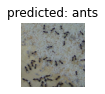

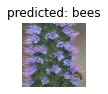

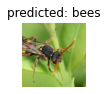

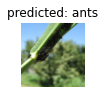

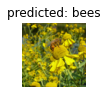

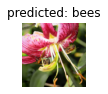

In [22]:
# can be run more than once and obtain different evaluations
visualize_model(model_ft)

# ConvNet as fixed feature extractor

We need to freeze all the network except the final layer.

In [23]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

# instead of this one: model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv.fc = SpinalNet()

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6829 Acc: 0.5369
val Loss: 0.6021 Acc: 0.7516

Epoch 1/24
----------
train Loss: 0.6182 Acc: 0.7049
val Loss: 0.4588 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5207 Acc: 0.7664
val Loss: 0.3164 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.3951 Acc: 0.8443
val Loss: 0.2668 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3590 Acc: 0.8607
val Loss: 0.2052 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4099 Acc: 0.7951
val Loss: 0.2070 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3274 Acc: 0.8730
val Loss: 0.2917 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.2991 Acc: 0.8811
val Loss: 0.1941 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3380 Acc: 0.8689
val Loss: 0.1677 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3574 Acc: 0.8443
val Loss: 0.1662 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3371 Acc: 0.8443
val Loss: 0.1791 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3553 Acc: 0.8443
val Loss: 0.1978 Acc: 0.9477

Ep

*It is Important to Note That the original reference used only fully connected layers instead of Spinal Network and the Accuracy was obtained as 0.954248 which is exactly the same but the training results are not exactly the same*